<a href="https://colab.research.google.com/github/SaMaJiT7/SaMaJiT7/blob/main/Kidney_Stone_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  !pip install tensorflow opencv-python matplotlib pandas scikit-learn
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split



In [2]:
# Install required libraries
!pip install tensorflow opencv-python matplotlib pandas scikit-learn

# Import essential libraries
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Environment setup completed!")
print(f"TensorFlow version: {tf.__version__}")



Environment setup completed!
TensorFlow version: 2.19.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"


# Check class folders
os.listdir(dataset_path)

['Stone', 'Normal']

In [5]:
import os

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    print(cls, len(os.listdir(cls_path)))

Stone 1477
Normal 5077


In [6]:
import shutil
import os

# Path in Google Drive
drive_path = "/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Copy to Colab local storage for faster access
local_path = "/content/kidney_stone_dataset"
shutil.copytree(drive_path, local_path)
print(f"Dataset copied to {local_path}")

Dataset copied to /content/kidney_stone_dataset


In [28]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation + validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training generator
train_generator = datagen.flow_from_directory(
    local_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',       # ✅ binary classification
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_directory(
    local_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 5244 images belonging to 2 classes.
Found 1310 images belonging to 2 classes.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_advanced_kidney_cnn():
    """Advanced CNN architecture for kidney stone detection"""

    model = models.Sequential([
        # Input normalization
        layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Already normalized, but good practice

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Global Average Pooling (more robust than Flatten)
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),

        # After (binary)
        layers.Dense(1, activation="sigmoid")
    ])

    # Advanced compilation with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",   # ✅
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
    )

    return model

# Create the model
model = create_advanced_kidney_cnn()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,439,393 (5.49 MB)

 Trainable params: 1,437,409 (5.48 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Reduce learning rate when validation AUC stops improving
lr_reduction = ReduceLROnPlateau(
    monitor='val_auc',    # metric to monitor
    factor=0.5,           # reduce LR by this factor
    patience=5,           # wait this many epochs before reducing
    verbose=1,
    min_lr=1e-7           # minimum learning rate
)

# Optional: Stop early if no improvement
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Optional: Save best model

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/best_kidney_stone_model.h5',
    monitor='val_auc',       # metric to monitor
    save_best_only=True,     # ✅ saves only the best model
    mode='max',              # maximize AUC
    verbose=1
)

from tensorflow.keras.callbacks import CSVLogger
log_csv = CSVLogger("training_log.csv", append=True)
callbacks = [lr_reduction, early_stop, checkpoint, log_csv]

In [23]:
from sklearn.utils.class_weight import compute_class_weight


# train_generator.classes gives an array of class indices
classes = np.unique(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Map class indices directly
class_weights = {i : w for i, w in zip(np.unique(train_generator.classes), class_weights)}

print("Class weights:", class_weights)

unique, counts = np.unique(train_generator.classes, return_counts=True)
print(dict(zip(unique, counts)))

Class weights: {np.int32(0): np.float64(0.6454948301329394), np.int32(1): np.float64(2.218274111675127)}
{np.int32(0): np.int64(4062), np.int32(1): np.int64(1182)}


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


In [25]:
# Print first batch file paths
for batch_images, batch_labels in train_generator:
    print("Sample image paths from generator:")
    print(train_generator.filepaths[:5])  # first 5 images
    break

Sample image paths from generator:
['/content/kidney_stone_dataset/Normal/Normal- (1912).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1913).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1914).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1915).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1916).jpg']


In [26]:
from tensorflow.keras.callbacks import Callback

class DebugDataPathCallback(Callback):
    def on_train_begin(self, logs=None):
        print("\n=== DEBUG: Checking dataset paths ===")
        # Only works if using ImageDataGenerator.flow_from_directory
        print("First 5 image paths from training generator:")
        print(train_generator.filepaths[:5])
        print("=== End of check ===\n")

# Add to callbacks
callbacks.append(DebugDataPathCallback())

In [29]:
# Train the model
print("Starting advanced training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,            # you can increase if needed
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)
print("Training completed!")


Starting advanced training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



=== DEBUG: Checking dataset paths ===
First 5 image paths from training generator:
['/content/kidney_stone_dataset/Normal/Normal- (1912).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1913).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1914).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1915).jpg', '/content/kidney_stone_dataset/Normal/Normal- (1916).jpg']
=== End of check ===

Epoch 1/50
  2/164 ━━━━━━━━━━━━━━━━━━━━ 56:02 21s/step - accuracy: 0.5469 - auc: 0.5195 - loss: 1.8878 - precision: 0.2362 - recall: 0.5220  

KeyboardInterrupt: 

In [21]:
model.save('/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/best_kidney_stone_model.keras')
print("✅ Best model saved to Drive!")

✅ Best model saved to Drive!


In [32]:
import numpy as np
from sklearn.metrics import f1_score

# Step 1: Get predictions for the test/validation generator
# Make sure shuffle=False to match labels correctly
train_generator.reset()
y_true = train_generator.classes  # True labels

# Predict probabilities
y_pred_prob = model.predict(train_generator, verbose=1)
# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Step 2: Compute metrics
accuracy = np.mean(y_pred == y_true)
precision = np.sum((y_pred == 1) & (y_true == 1)) / (np.sum(y_pred == 1) + 1e-7)
recall = np.sum((y_pred == 1) & (y_true == 1)) / (np.sum(y_true == 1) + 1e-7)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

# Compute AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, y_pred_prob)

# Step 3: Print results
print("=== FINAL TEST RESULTS ===")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step
=== FINAL TEST RESULTS ===
Accuracy: 0.2254 (22.54%)
Precision: 0.2254
Recall: 1.0000
F1-Score: 0.3679
AUC: 0.4973


In [8]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model (native Keras format)
model = load_model('/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/best_kidney_stone_model.keras')
print("✅ Model loaded successfully!")

# Check model summary
model.summary()


✅ Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,876,804 (10.97 MB)

 Trainable params: 1,437,409 (5.48 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 1,437,411 (5.48 MB)

In [9]:
def predict_kidney_stone(image_path, model, threshold=0.5):
    """
    Predict kidney stone from a single CT scan image

    Args:
        image_path: Path to the CT scan image
        model: Trained CNN model
        threshold: Decision threshold (default 0.5)

    Returns:
        prediction: Probability score
        classification: 'Stone Detected' or 'Normal'
        confidence: Confidence percentage
    """

    # Preprocess the image (same as training preprocessing)
    img = cv2.imread(image_path)

    if img is None:
        return None, "Error: Could not load image", 0

    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to model input size
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)

    # Normalize to [0, 1]
    img = img.astype('float32') / 255.0

    # Add batch dimension
    img_batch = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img_batch, verbose=0)[0][0]

    # Classify based on threshold
    if prediction >= threshold:
        classification = "Stone Detected"
        confidence = prediction * 100
    else:
        classification = "Normal Kidney"
        confidence = (1 - prediction) * 100

    return prediction, classification, confidence

# Test function
def visualize_prediction(image_path, model):
    """Visualize the prediction result"""

    # Load and display original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get prediction
    prediction, classification, confidence = predict_kidney_stone(image_path, model)

    if prediction is None:
        print("Error loading image")
        return

    # Create visualization
    plt.figure(figsize=(12, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original CT Scan")
    plt.axis('off')

    # Preprocessed image with prediction
    preprocessed = cv2.resize(img_rgb, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed)

    # Color code the result
    color = 'red' if 'Stone' in classification else 'green'
    plt.title(f'{classification}\nConfidence: {confidence:.1f}%\nProbability: {prediction:.3f}',
              color=color, fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"=== PREDICTION RESULTS ===")
    print(f"Classification: {classification}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Raw Probability: {prediction:.4f}")
    print(f"Threshold Used: 0.5")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_kidney_stone(image_path, model, threshold=0.6):
    """Predict kidney stone from a single CT scan image"""
    img = cv2.imread(image_path)
    if img is None:
        return None, "Error: Could not load image", 0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
    img = img.astype('float32') / 255.0
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch, verbose=0)[0][0]
    if prediction >= threshold:
        classification = "Stone Detected"
        confidence = prediction * 100
    else:
        classification = "Normal Kidney"
        confidence = (1 - prediction) * 100
    return prediction, classification, confidence

def visualize_prediction(image_path, model):
    """Visualize prediction result on a single image"""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    prediction, classification, confidence = predict_kidney_stone(image_path, model)
    if prediction is None:
        print("Error loading image")
        return
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    color = 'red' if 'Stone' in classification else 'green'
    plt.title(f'{classification}\nConfidence: {confidence:.1f}%\nProbability: {prediction:.3f}',
              color=color, fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.show()


In [10]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/best_kidney_stone_model.keras')

Found 123 images in the test folder


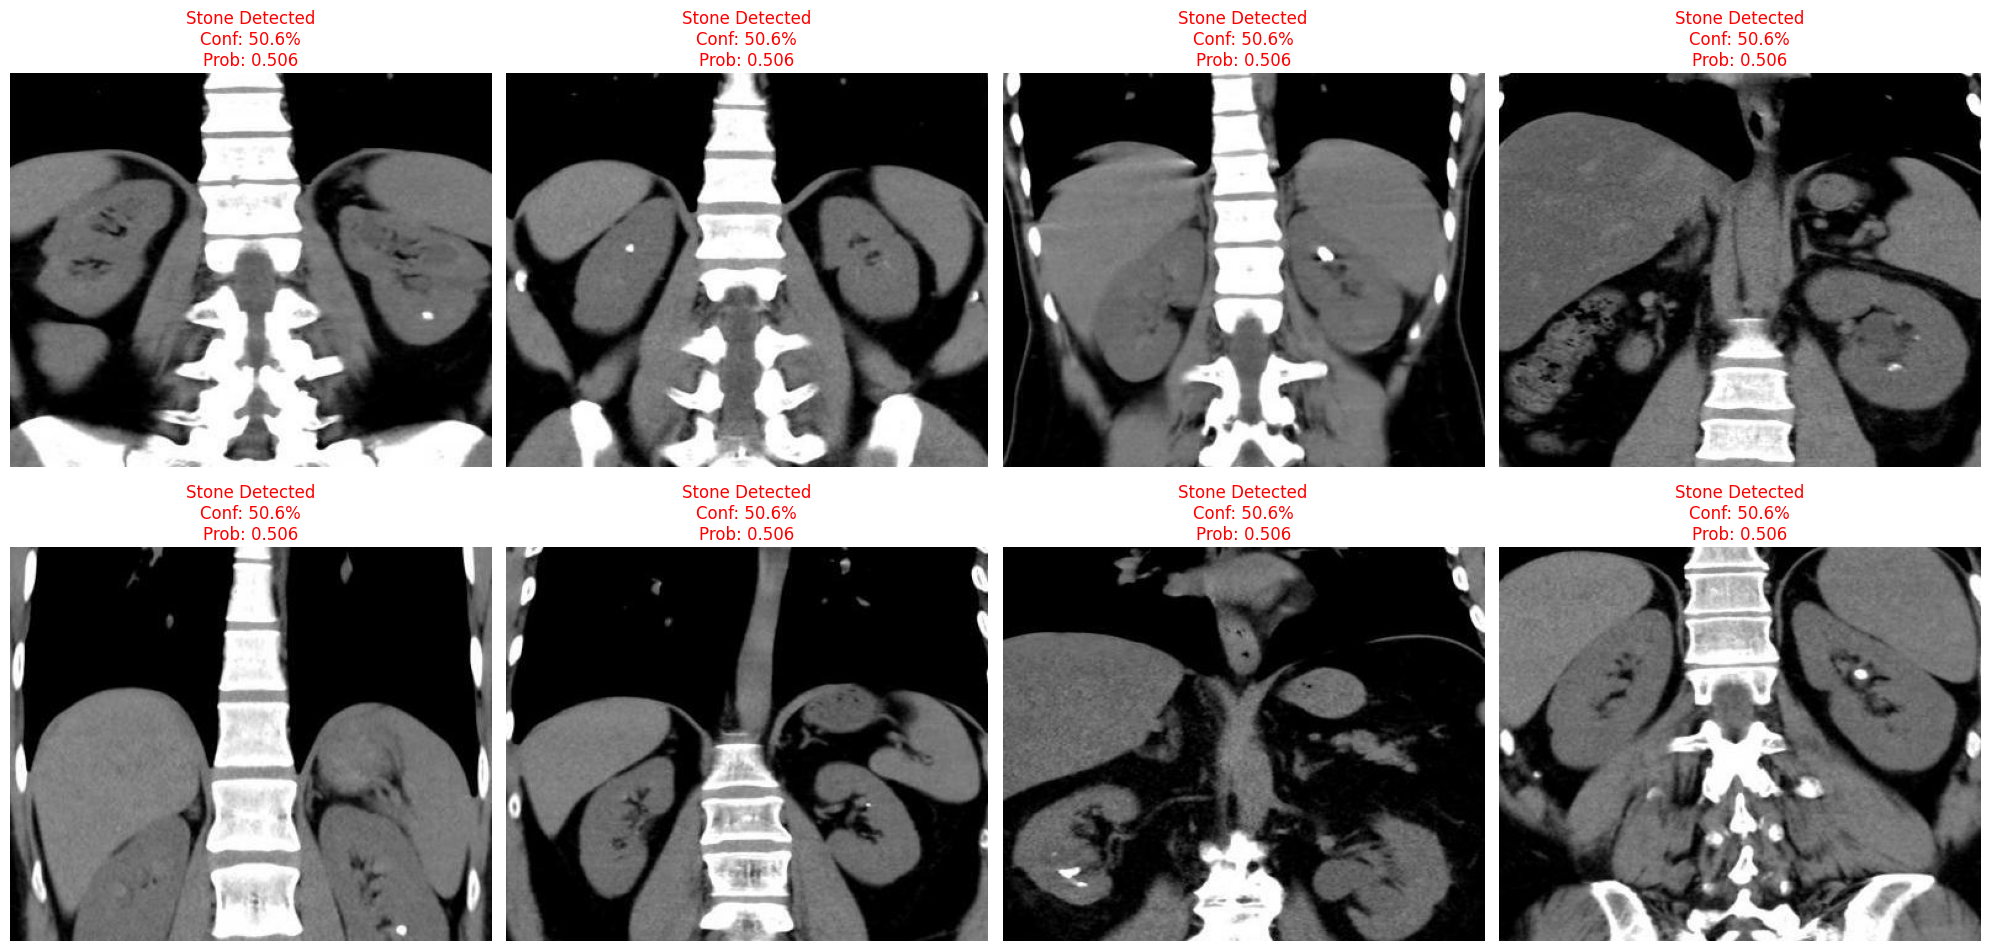

In [34]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Make sure your model is already loaded
# model = load_model('best_kidney_stone_model.keras')

# Path to test images
test_folder = '/content/drive/MyDrive/Kidney_stone_dataset/kidney_stonefinal/test/images'

# Supported image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Collect all image paths
all_images = [os.path.join(test_folder, f) for f in os.listdir(test_folder)
              if os.path.splitext(f)[1].lower() in image_extensions]

print(f"Found {len(all_images)} images in the test folder")

if len(all_images) == 0:
    raise ValueError("No images found! Check your folder path and contents.")

# Sample images to visualize
num_samples = min(8, len(all_images))
sample_images = random.sample(all_images, num_samples)

# Setup matplotlib figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Failed to load image: {img_path}")
        axes[i].axis('off')
        axes[i].set_title("Failed to load", color='red')
        continue

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Make prediction
    prediction, classification, confidence = predict_kidney_stone(img_path, model)

    # Display
    axes[i].imshow(img_rgb)
    axes[i].set_title(f'{classification}\nConf: {confidence:.1f}%\nProb: {prediction:.3f}',
                      color='red' if 'Stone' in classification else 'green')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
import os

def upload_and_predict(model, threshold=0.6):
    """Upload one or more CT scan images and visualize predictions"""
    print("Please upload CT scan images (JPG, JPEG, PNG formats):")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n=== Analyzing {filename} ===")

        # Save temporarily
        with open(filename, 'wb') as f:
            f.write(uploaded[filename])

        # Use your existing visualization function
        visualize_prediction(filename, model)

        # Clean up
        os.remove(filename)


        #TEsting the the model
        upload_and_predict(model)


In [ ]:
import tensorflow as tf
from collections import Counter

def get_label_counts(dataset):
    labels_list = []
    for _, labels in dataset:
        # Flatten each batch of labels
        labels_list.extend(labels.numpy().flatten())
    return Counter(labels_list)

train_counts = get_label_counts(train_ds)
val_counts = get_label_counts(val_ds)

print("Training set label distribution:", train_counts)
print("Validation set label distribution:", val_counts)


In [ ]:
def batch_predict(image_folder, model):
    """Predict on multiple images in a folder"""

    import glob
    import pandas as pd

    # Find all images
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
        image_files.extend(glob.glob(os.path.join(image_folder, ext)))

    if not image_files:
        print("No images found in the specified folder")
        return

    results = []

    print(f"Processing {len(image_files)} images...")

    for i, img_path in enumerate(image_files):
        if i % 10 == 0:
            print(f"Processed {i}/{len(image_files)} images")

        prediction, classification, confidence = predict_kidney_stone(img_path, model)

        if prediction is not None:
            results.append({
                'filename': os.path.basename(img_path),
                'classification': classification,
                'confidence': f"{confidence:.2f}%",
                'probability': f"{prediction:.4f}"
            })

    # Create results DataFrame
    df_results = pd.DataFrame(results)

    # Display summary
    stone_count = sum(1 for r in results if 'Stone' in r['classification'])
    normal_count = len(results) - stone_count

    print(f"\n=== BATCH PREDICTION SUMMARY ===")
    print(f"Total images processed: {len(results)}")
    print(f"Stone detected: {stone_count}")
    print(f"Normal kidneys: {normal_count}")
    print(f"Stone detection rate: {stone_count/len(results)*100:.1f}%")

    return df_results

# Example usage:
# results_df = batch_predict("./new_ct_scans/", model)
# print(results_df)


In [ ]:
def detailed_prediction_analysis(image_path, model):
    """Provide detailed analysis of the prediction"""

    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224)).astype('float32') / 255.0
    img_batch = np.expand_dims(img_resized, axis=0)

    # Get prediction
    prediction = model.predict(img_batch, verbose=0)[0][0]

    # Analysis
    if prediction >= 0.8:
        certainty = "Very High"
        recommendation = "Strong indication of kidney stone. Recommend immediate medical consultation."
    elif prediction >= 0.6:
        certainty = "High"
        recommendation = "Likely kidney stone detected. Medical evaluation recommended."
    elif prediction >= 0.4:
        certainty = "Moderate"
        recommendation = "Inconclusive result. Consider additional imaging or medical review."
    elif prediction >= 0.2:
        certainty = "Low"
        recommendation = "Likely normal kidney. Monitor for symptoms."
    else:
        certainty = "Very Low"
        recommendation = "Normal kidney appearance. No immediate concern indicated."

    # Visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original CT Scan")
    plt.axis('off')

    # Preprocessed image
    plt.subplot(1, 3, 2)
    plt.imshow(img_resized)
    plt.title("Preprocessed for Model")
    plt.axis('off')

    # Prediction gauge
    plt.subplot(1, 3, 3)
    colors = ['green' if prediction < 0.5 else 'red']
    plt.barh(['Stone Probability'], [prediction], color=colors)
    plt.xlim(0, 1)
    plt.xlabel('Probability')
    plt.title(f'Prediction: {prediction:.3f}')

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print(f"=== DETAILED ANALYSIS ===")
    print(f"Kidney Stone Probability: {prediction:.4f}")
    print(f"Confidence Level: {certainty}")
    print(f"Classification: {'Stone Detected' if prediction >= 0.5 else 'Normal Kidney'}")
    print(f"Medical Recommendation: {recommendation}")
    print(f"\n⚠️ IMPORTANT: This is an AI prediction tool and should not replace professional medical diagnosis.")

# Example usage:
# detailed_prediction_analysis("path/to/ct_scan.jpg", model)


In [ ]:
# Check training history
if 'history' in locals():
  import matplotlib.pyplot as plt

# Check if history exists
if 'history' in locals():
    # Extract metrics
    metrics = history.history

    # List of metrics to plot
    plot_metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss',
                    'precision', 'val_precision', 'recall', 'val_recall',
                    'auc', 'val_auc']

    # Create subplots
    fig, axes = plt.subplots(5, 1, figsize=(10, 25))

    # Accuracy
    axes[0].plot(metrics['accuracy'], label='Training')
    axes[0].plot(metrics['val_accuracy'], label='Validation')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Loss
    axes[1].plot(metrics['loss'], label='Training')
    axes[1].plot(metrics['val_loss'], label='Validation')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Precision
    axes[2].plot(metrics['precision'], label='Training')
    axes[2].plot(metrics['val_precision'], label='Validation')
    axes[2].set_title('Model Precision')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Precision')
    axes[2].legend()

    # Recall
    axes[3].plot(metrics['recall'], label='Training')
    axes[3].plot(metrics['val_recall'], label='Validation')
    axes[3].set_title('Model Recall')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Recall')
    axes[3].legend()

    # AUC
    axes[4].plot(metrics['auc'], label='Training')
    axes[4].plot(metrics['val_auc'], label='Validation')
    axes[4].set_title('Model AUC')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('AUC')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

    # Print final values
    print("=== FINAL METRICS ===")
    for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'precision', 'val_precision', 'recall', 'val_recall', 'auc', 'val_auc']:
        print(f"{key}: {metrics[key][-1]:.4f}")



    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_auc = history.history['val_auc'][-1]


    print(f"Final validation AUC: {final_val_auc:.3f}")

    print(f"Final training accuracy: {final_train_acc:.3f}")
    print(f"Final validation accuracy: {final_val_acc:.3f}")

    #Loss Checking
    print(f"Final training loss: {final_train_loss:.3f}")
    print(f"Final validation loss: {final_val_loss:.3f}")

    if final_train_acc < 0.7:
        print("⚠️ Model didn't train properly - accuracy too low")
    elif abs(final_train_acc - final_val_acc) > 0.2:
        print("⚠️ Model is overfitting")


In [ ]:
def debug_preprocessing(image_path):
    """Debug preprocessing steps"""

    # Load original image
    img_original = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # Apply same preprocessing as training
    img_processed = cv2.resize(img_rgb, (224, 224))
    img_normalized = img_processed.astype('float32') / 255.0

    # Visualize preprocessing steps
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(img_processed)
    axes[1].set_title("Resized (224x224)")
    axes[1].axis('off')

    axes[2].imshow(img_normalized)
    axes[2].set_title("Normalized [0,1]")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Original shape: {img_original.shape}")
    print(f"Processed shape: {img_normalized.shape}")
    print(f"Value range: [{img_normalized.min():.3f}, {img_normalized.max():.3f}]")

    return img_normalized

# Test preprocessing on a problematic image
# processed_img = debug_preprocessing("path/to/problematic/image.jpg")


In [ ]:
# Manually correct labels for obvious cases
def fix_labels_manually(image_paths, labels):
    """Manually review and fix obvious labeling errors"""

    corrected_labels = labels.copy()

    # Display images for manual review
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i in range(min(10, len(image_paths))):
        img = cv2.imread(image_paths[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        current_label = "Stone" if labels[i] == 1 else "Normal"
        axes[i].set_title(f'Image {i}\nCurrent: {current_label}\nPath: {os.path.basename(image_paths[i])}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # You can manually adjust labels here based on visual inspection
    # Example: corrected_labels[0] = 0  # Change first image to Normal

    return corrected_labels

# Use this if you suspect labeling issues
# corrected_labels = fix_labels_manually(image_files[:10], labels[:10])


In [ ]:
# Test different thresholds
def find_optimal_threshold(model, X_test, y_test):
    """Find the best threshold for your specific dataset"""

    # Get prediction probabilities
    predictions_prob = model.predict(X_test)

    thresholds = np.arange(0.1, 0.9, 0.1)
    best_threshold = 0.5
    best_accuracy = 0

    for threshold in thresholds:
        predictions_binary = (predictions_prob > threshold).astype(int)
        accuracy = np.mean(predictions_binary.flatten() == y_test)

        print(f"Threshold {threshold:.1f}: Accuracy = {accuracy:.3f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    print(f"\nBest threshold: {best_threshold:.1f} (Accuracy: {best_accuracy:.3f})")
    return best_threshold

# Find optimal threshold
# if 'X_test' in locals() and 'y_test' in locals():
#     optimal_threshold = find_optimal_threshold(model, X_test, y_test)


In [ ]:
# Try transfer learning with a pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

def create_transfer_learning_model():
    """Create a more robust model using transfer learning"""

    # Load pre-trained VGG16
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Create and train transfer learning model
# transfer_model = create_transfer_learning_model()
# transfer_model.summary()


In [ ]:
def debug_single_prediction(image_path, model, true_label=None):
    """Debug a specific prediction in detail"""

    # Load and preprocess
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_processed = cv2.resize(img_rgb, (224, 224)).astype('float32') / 255.0
    img_batch = np.expand_dims(img_processed, axis=0)

    # Get prediction
    prediction = model.predict(img_batch, verbose=0)[0][0]
    predicted_class = 1 if prediction >= 0.5 else 0

    # Visualization
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_processed)
    plt.title("Preprocessed")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.bar(['Normal', 'Stone'], [1-prediction, prediction],
            color=['green' if prediction < 0.5 else 'lightgreen',
                   'red' if prediction >= 0.5 else 'lightcoral'])
    plt.title(f'Prediction: {prediction:.3f}')
    plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

    print(f"=== DEBUGGING RESULTS ===")
    print(f"File: {os.path.basename(image_path)}")
    print(f"Prediction probability: {prediction:.4f}")
    print(f"Predicted class: {predicted_class} ({'Stone' if predicted_class == 1 else 'Normal'})")

    if true_label is not None:
        print(f"True label: {true_label} ({'Stone' if true_label == 1 else 'Normal'})")
        print(f"Correct prediction: {'✅ Yes' if predicted_class == true_label else '❌ No'}")

    # Analysis
    if prediction > 0.8:
        print("Model is very confident about stone presence")
    elif prediction > 0.6:
        print("Model is moderately confident about stone presence")
    elif prediction > 0.4:
        print("Model is uncertain - close to decision boundary")
    elif prediction > 0.2:
        print("Model leans toward normal kidney")
    else:
        print("Model is confident about normal kidney")

# Test on a specific problematic image
# debug_single_prediction("path/to/wrong/prediction.jpg", model, true_label=1)


In [ ]:
# Verify model architecture
def check_model_health(model):
    """Check if model architecture is reasonable"""

    print("=== MODEL HEALTH CHECK ===")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Trainable parameters: {sum([layer.count_params() for layer in model.layers if layer.trainable]):,}")

    # Check layer outputs
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'output_shape'):
            print(f"Layer {i}: {layer.name} -> {layer.output_shape}")

    # Check final layer
    final_layer = model.layers[-1]
    if hasattr(final_layer, 'activation'):
        print(f"Final activation: {final_layer.activation.__name__}")

    # Warnings
    if model.count_params() > 50_000_000:
        print("⚠️ Model might be too complex (overfitting risk)")
    elif model.count_params() < 100_000:
        print("⚠️ Model might be too simple (underfitting risk)")

# Run health check
check_model_health(model)


In [16]:
# Create a dummy batch
dummy = np.random.rand(1,224,224,3).astype('float32')

# Run one forward pass
_ = model.predict(dummy, verbose=0)

164/164 ━━━━━━━━━━━━━━━━━━━━ 577s 4s/step
Confusion Matrix:
[[   0 4062]
 [   0 1182]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      4062
       Stone       0.23      1.00      0.37      1182

    accuracy                           0.23      5244
   macro avg       0.11      0.50      0.18      5244
weighted avg       0.05      0.23      0.08      5244


ROC-AUC: 0.490


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


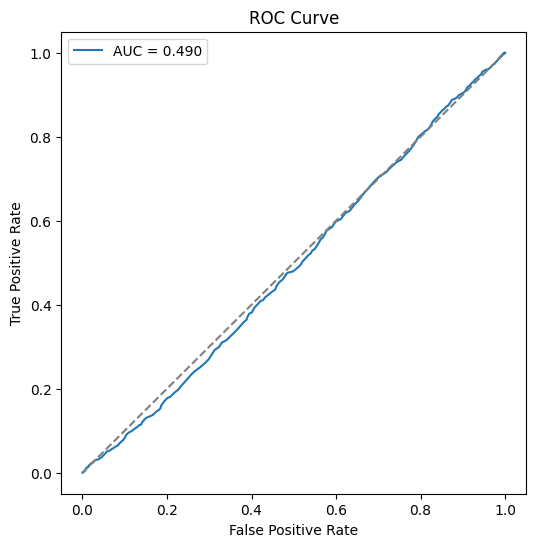

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# ✅ Reset generator so predictions match labels
train_generator.reset()

# True labels
y_true = train_generator.classes

# Predictions
y_pred_probs = model.predict(train_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

# ROC-AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC-AUC: {auc:.3f}")

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()